<a href="https://colab.research.google.com/github/Realosunboy6/550-Stocks-Portfolio-Theory-Python-Julia-/blob/main/AMPL_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Modeling with Python & AMPL

**Graduate Optimization Course**  
Department of Industrial & Systems Engineering, NIU

---

This notebook demonstrates three different approaches to solve optimization problems using AMPL and Python:

1. **Inline Method**: Define model directly in Python using `eval()`
2. **Model File Method**: Use separate `.mod` file with Python data injection
3. **Full Separation Method**: Use both `.mod` and `.dat` files

We'll use the **Land Allocation Problem** as our running example.

---

## Problem Description: Land Allocation

The Forest Service needs to allocate **1,000 acres** of public land between two uses:

| Use | Return (\$/acre) | Cost (\$/acre) |
|:----|:-----------------|:---------------|
| Timber ($X_1$) | 500 | 100 |
| Preservation ($X_2$) | 200 | 20 |

**Constraints:**
- Total land available: 1,000 acres
- Budget: \$50,000
- Policy requirement: At least 200 acres for preservation

**Objective:** Maximize Net Present Value (NPV)

---

## Mathematical Formulation

**Decision Variables:**
- $X_1$ = Acres allocated to Timber
- $X_2$ = Acres allocated to Preservation

**Objective Function:**

$$\max Z = 500X_1 + 200X_2$$

**Subject to:**

$$X_1 + X_2 \leq 1000 \quad \text{(Land)}$$

$$100X_1 + 20X_2 \leq 50000 \quad \text{(Budget)}$$

$$X_2 \geq 200 \quad \text{(Policy)}$$

$$X_1, X_2 \geq 0$$

---

## Setup: Install AMPL and Solvers

We use `ampl_notebook()` which is designed specifically for cloud notebook environments like Google Colab.

In [ ]:
# Install AMPL Python API
%pip install amplpy -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 23.6 MB/s eta 0:00:00


In [ ]:
from amplpy import AMPL, ampl_notebook

# Initialize AMPL with solvers for Colab environment
# Get your own free license at: https://ampl.com/ce or https://ampl.com/courses
ampl_notebook(
    modules=["highs"],  # Open-source solver; add "gurobi", "cplex" if needed
    license_uuid="40a0a160-668d-492d-be4a-236079be8ff7"
)

print("AMPL environment ready!")

Licensed to Bundle #7384.7942 expiring 20260531: ISYE 671 linear optimization and network flows, Prof. Ziteng Wang, Northern Illinois University.
AMPL environment ready!


---

## Method 1: Inline Model Definition

The **Notebook approach** — perfect for teaching and quick prototypes.

In [ ]:
# Create a model instance for the land allocation problem
land_model = AMPL()

# Define model inline using eval()
land_model.eval('''
    set USES;
    param return_per_acre {USES};
    param cost_per_acre {USES};
    param total_land;
    param budget_limit;
    param min_preservation;

    var Acres {u in USES} >= 0;

    maximize Total_NPV:
        sum {u in USES} return_per_acre[u] * Acres[u];

    subject to Land_Limit:
        sum {u in USES} Acres[u] <= total_land;

    subject to Budget_Limit:
        sum {u in USES} cost_per_acre[u] * Acres[u] <= budget_limit;

    subject to Min_Preservation:
        Acres['Preservation'] >= min_preservation;
''')
print('Model defined!')

Model defined!


In [ ]:
# Load data from Python dictionaries
land_model.set['USES'] = ['Timber', 'Preservation']
land_model.param['return_per_acre'] = {'Timber': 500, 'Preservation': 200}
land_model.param['cost_per_acre'] = {'Timber': 100, 'Preservation': 20}
land_model.param['total_land'] = 1000
land_model.param['budget_limit'] = 50000
land_model.param['min_preservation'] = 200
print('Data loaded!')

Data loaded!


In [ ]:
# Solve
land_model.option['solver'] = 'highs'
land_model.solve()
print(f"Solver status: {land_model.get_value('solve_result')}")

HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 312500
2 simplex iterations
0 barrier iterations
Solver status: solved


In [ ]:
# Display results
print('=' * 50)
print('OPTIMAL SOLUTION')
print('=' * 50)
print(f"\nMaximum NPV: ${land_model.obj['Total_NPV'].value():,.2f}")

print('\nAllocation:')
for u in ['Timber', 'Preservation']:
    val = land_model.var['Acres'][u].value()
    print(f"  {u}: {val:,.0f} acres")

print('\nShadow Prices:')
print(f"  Land: ${land_model.con['Land_Limit'].dual():,.2f}/acre")
print(f"  Budget: ${land_model.con['Budget_Limit'].dual():,.4f}/dollar")
print(f"  Min Preservation: ${land_model.con['Min_Preservation'].dual():,.2f}/acre")

OPTIMAL SOLUTION

Maximum NPV: $312,500.00

Allocation:
  Timber: 375 acres
  Preservation: 625 acres

Shadow Prices:
  Land: $125.00/acre
  Budget: $3.7500/dollar
  Min Preservation: $0.00/acre


### Interpreting Shadow Prices

| Shadow Price | Meaning |
|:-------------|:--------|
| Land $> 0$ | Land is fully used. Each additional acre increases NPV by this amount. |
| Budget $> 0$ | Budget is fully used. Each additional dollar increases NPV by this amount. |
| $= 0$ | Constraint is not binding (slack exists). |

---

## Method 2: Separate Model File (.mod)

The **Production approach** — model in file, data from Python.

We use the `%%writefile` magic command to create the file directly.

In [ ]:
%%writefile land_allocation.mod
# ===========================================
# Land Allocation Model
# ===========================================

# --- SETS ---
set USES;

# --- PARAMETERS ---
param return_per_acre {USES};
param cost_per_acre {USES};
param total_land;
param budget_limit;
param min_preservation;

# --- DECISION VARIABLES ---
var Acres {u in USES} >= 0;

# --- OBJECTIVE ---
maximize Total_NPV:
    sum {u in USES} return_per_acre[u] * Acres[u];

# --- CONSTRAINTS ---
subject to Land_Limit:
    sum {u in USES} Acres[u] <= total_land;

subject to Budget_Limit:
    sum {u in USES} cost_per_acre[u] * Acres[u] <= budget_limit;

subject to Min_Preservation:
    Acres['Preservation'] >= min_preservation;

Writing land_allocation.mod


In [ ]:
# Create a new model instance and load the .mod file
land_model2 = AMPL()
land_model2.read('land_allocation.mod')

# Load data from Python
land_model2.set['USES'] = ['Timber', 'Preservation']
land_model2.param['return_per_acre'] = {'Timber': 500, 'Preservation': 200}
land_model2.param['cost_per_acre'] = {'Timber': 100, 'Preservation': 20}
land_model2.param['total_land'] = 1000
land_model2.param['budget_limit'] = 50000
land_model2.param['min_preservation'] = 200

# Solve
land_model2.option['solver'] = 'highs'
land_model2.solve()

print(f"NPV: ${land_model2.obj['Total_NPV'].value():,.2f}")
print(land_model2.var['Acres'].get_values().to_pandas())

HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 312500
2 simplex iterations
0 barrier iterations
NPV: $312,500.00
              Acres.val
Preservation        625
Timber              375


---

## Method 3: Full Separation (.mod + .dat)

The **Enterprise approach** — complete separation of model and data.

This is the recommended approach for production systems and collaboration.

In [ ]:
%%writefile land_allocation.dat
# ===========================================
# Data for Land Allocation Problem
# ===========================================

set USES := Timber Preservation;

param return_per_acre :=
    Timber       500
    Preservation 200;

param cost_per_acre :=
    Timber       100
    Preservation 20;

param total_land := 1000;
param budget_limit := 50000;
param min_preservation := 200;

Writing land_allocation.dat


In [ ]:
# Create model instance and load both .mod and .dat files
land_model3 = AMPL()
land_model3.read('land_allocation.mod')
land_model3.read_data('land_allocation.dat')

# Solve
land_model3.option['solver'] = 'highs'
land_model3.solve()

print('=' * 50)
print('METHOD 3 RESULTS (.mod + .dat)')
print('=' * 50)
print(f"NPV: ${land_model3.obj['Total_NPV'].value():,.2f}")
print(land_model3.var['Acres'].get_values().to_pandas())

HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 312500
2 simplex iterations
0 barrier iterations
METHOD 3 RESULTS (.mod + .dat)
NPV: $312,500.00
              Acres.val
Preservation        625
Timber              375


---

## Sensitivity Analysis

Let's explore how the solution changes with different budget levels.

In [ ]:
import pandas as pd

# Test different budget levels
budgets = [30000, 40000, 50000, 60000, 70000, 80000]
results = []

for budget in budgets:
    # Create a fresh model instance for each scenario
    scenario = AMPL()
    scenario.read('land_allocation.mod')
    scenario.read_data('land_allocation.dat')
    scenario.param['budget_limit'] = budget  # Override the data file value
    scenario.option['solver'] = 'highs'
    scenario.solve()

    results.append({
        'Budget': budget,
        'NPV': scenario.obj['Total_NPV'].value(),
        'Timber': scenario.var['Acres']['Timber'].value(),
        'Preservation': scenario.var['Acres']['Preservation'].value()
    })

df = pd.DataFrame(results)
print('Sensitivity Analysis: Budget Variations')
print(df.to_string(index=False))

HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 237500
2 simplex iterations
0 barrier iterations
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 275000
2 simplex iterations
0 barrier iterations
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 312500
2 simplex iterations
0 barrier iterations
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 350000
2 simplex iterations
0 barrier iterations
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 387500
2 simplex iterations
0 barrier iterations
HiGHS 1.11.0: HiGHS 1.11.0: optimal solution; objective 425000
2 simplex iterations
0 barrier iterations
Sensitivity Analysis: Budget Variations
 Budget      NPV  Timber  Preservation
  30000 237500.0   125.0         875.0
  40000 275000.0   250.0         750.0
  50000 312500.0   375.0         625.0
  60000 350000.0   500.0         500.0
  70000 387500.0   625.0         375.0
  80000 4250

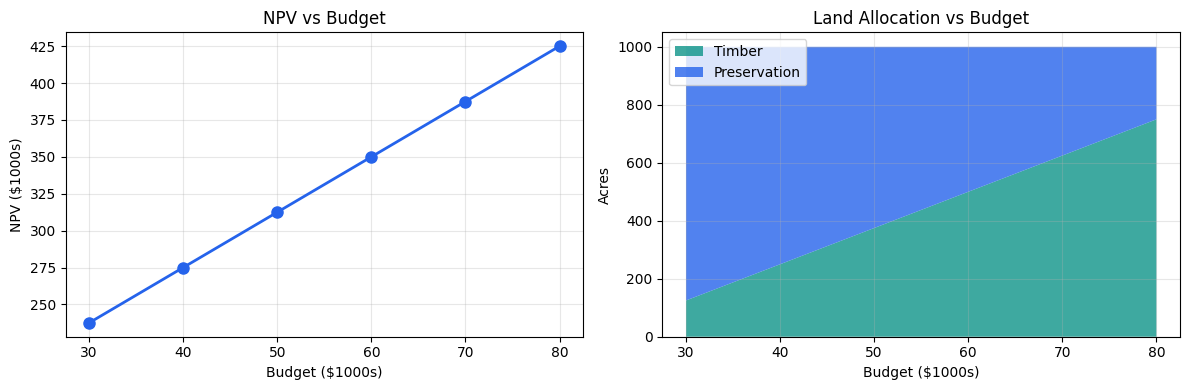

In [ ]:
# Visualize results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# NPV vs Budget
axes[0].plot(df['Budget']/1000, df['NPV']/1000, 'o-', color='#2563eb', linewidth=2, markersize=8)
axes[0].set_xlabel('Budget ($1000s)')
axes[0].set_ylabel('NPV ($1000s)')
axes[0].set_title('NPV vs Budget')
axes[0].grid(True, alpha=0.3)

# Land Allocation vs Budget
axes[1].stackplot(df['Budget']/1000, df['Timber'], df['Preservation'],
                  labels=['Timber', 'Preservation'], colors=['#0d9488', '#2563eb'], alpha=0.8)
axes[1].set_xlabel('Budget ($1000s)')
axes[1].set_ylabel('Acres')
axes[1].set_title('Land Allocation vs Budget')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Summary: Choosing the Right Method

| Method | When to Use | Pros | Cons |
|:-------|:------------|:-----|:-----|
| **Inline** | Teaching, prototypes | Quick to write | Hard to debug large models |
| **.mod only** | Medium projects | Reusable model | Data still in Python |
| **.mod + .dat** | Production, batch jobs | Full separation | More files to manage |

---

## Next Steps

1. **Assignment**: Re-implement the "Ohio National Bank" model using `.mod + .dat`
2. **Reading**: AMPL Book Chapter 2 (data file syntax)
3. **Explore**: Try different solvers (Gurobi, CPLEX with academic license)